In [1]:
# Core
import datetime
import os
import glob
import tempfile
import sys
import pickle
import copy

# Analysis 
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt

# Debugging 
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
from tint import animate
from tint.visualization import plot_tracks_horiz_cross

# CPOL convenience functions
import CPOL_func as cf


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
filenames = sorted(glob.glob('/g/data/w40/esh563/lind04/dbz/*.nc'))

In [2]:
def test():
#     filenames = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-10 09:00'), 
#                   np.datetime64('2006-02-10 10:00'), 
#                   np.timedelta64(10, 'm'))
#     )[0]

    filenames = sorted(glob.glob('/g/data/w40/esh563/lind04/dbz/*.nc'))

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl', 
              'rb') as f:
        b_ind_set = pickle.load(f)

    # Define settings for tracking
    settings = {
        'MIN_SIZE' : [40, 400, 800], # square km
        'FIELD_THRESH' : ['convective', 20, 15], # DbZ
        'ISO_THRESH' : [10, 10, 10], # DbZ
        'GS_ALT' : 3000,
        'SEARCH_MARGIN' : 10000, # m. This is just for object matching step:
        # does not affect flow vectors.
        'FLOW_MARGIN' : 40000, # m. Margin around object over which to
        # perform phase correlation.
        'LEVELS' : np.array( # m
            [[3000, 3500], 
             [3500, 7500],
             [7500, 10000]]
        ),
        'TRACK_INTERVAL' : 0,
        'BOUNDARY_GRID_CELLS' : b_ind_set,
        'UPDRAFT_START': 3000
    }

    tracks_obj  = tint.Cell_tracks()

    for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                      'TRACK_INTERVAL', 'ISO_THRESH', 'SEARCH_MARGIN',
                      'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS', 'UPDRAFT_START'
                     ]:
        tracks_obj.params[parameter] = settings[parameter]

    # Calculate tracks
    # %lprun -T lprof0 -f get_filtered_frame_steiner tracks_obj.get_tracks(grids)
    tracks_obj.get_tracks(grids)
    tracks_obj = cf.get_reanalysis_vars(tracks_obj)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                     + 'tracks_obj_wrf.pkl'.format(dt))

    with open(out_file_name, 'wb') as f:
        pickle.dump(tracks_obj, f)
        
    return tracks_obj
        
if __name__ == '__main__':
    try:
        tracks_obj = test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)
        
# print(open('lprof0', 'r').read())

Calculating additional tracks properties.
Calculating system tracks.


Time elapsed: 2.3 minutes
Adding data from Monash Reanalysis
Input already a dataframe.
Input already a dataframe.
Input already a dataframe.


In [2]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_com_2001_2014.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [4]:
filenames = sorted(glob.glob('/g/data/w40/esh563/lind04/dbz/*.nc'))
# filenames = filenames[-24:-20]

In [8]:
tracks_obj.system_tracks

,,,grid_x,grid_y,com_x,com_y,lon,lat,u,v,mergers,u_shift,...,v_shear,u_cl,v_cl,shear_dir,shear_mag,prop_dir,prop_mag,u_prop,v_prop,shear_rel_prop_dir
scan,time,uid,,,,,,,,,,,,,,,,,,,,,
110,2006-02-09 06:20:00,0,-67677.8,79753.4,-66691.7,80458.1,130.43235,-11.52492,NaN,NaN,{},-4.167,...,0.81290,-4.337732,1.267153,175.647003,10.711,-82.326,1.279,0.170732,-1.267153,102.027
111,2006-02-09 06:30:00,0,-70494.0,79291.7,-69762.5,80262.5,130.40416,-11.52662,NaN,NaN,{},-4.167,...,0.81290,-4.337732,1.267153,175.647003,10.711,-82.326,1.279,0.170732,-1.267153,102.027
120,2006-02-09 08:00:00,1,133422.0,-132865.1,134152.5,-132859.9,132.28480,-13.44115,NaN,NaN,{},-10.417,...,0.81290,-4.337732,1.267153,175.647003,10.711,-159.201,6.503,-6.079268,-2.309153,25.152
121,2006-02-09 08:10:00,1,129362.5,-119350.0,129951.4,-120279.8,132.24541,-13.32820,NaN,NaN,{},-9.722,...,0.81290,-4.337732,1.267153,175.647003,10.711,-159.986,5.730,-5.384268,-1.961153,24.367
122,2006-02-09 08:20:00,1,124189.3,-119595.9,124612.9,-120393.0,132.19608,-13.32943,-15.013,7.623,{},-8.333,...,0.81290,-4.337732,1.267153,175.647003,10.711,-179.754,3.995,-3.995268,-0.017153,4.599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2006-02-13 11:20:00,30,-1895.8,-82541.7,-814.2,-82377.0,131.03693,-12.99000,-10.636,2.209,{},-10.000,...,2.99056,-7.948161,0.122460,160.076004,8.776,136.304,2.838,-2.051839,1.960540,-23.772
717,2006-02-13 11:30:00,30,-10699.8,-78242.5,-9285.3,-78032.9,130.95876,-12.95092,-10.455,2.967,{},-10.833,...,2.99056,-7.948161,0.122460,160.076004,8.776,140.506,3.738,-2.884839,2.377540,-19.570
718,2006-02-13 11:40:00,30,-15298.9,-79556.2,-14912.3,-78458.8,130.90684,-12.95473,-11.262,4.604,{},NaN,...,2.99056,-7.948161,0.122460,160.076004,8.776,NaN,NaN,NaN,NaN,NaN


In [ ]:
def test():
    lon_min = 131.0 - 1.6
    lon_max = 131.0 + 1.6

    lat_max = -12.2 + 1.6
    lat_min = -12.2 - 1.6

#     [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
#         np.arange(np.datetime64('2006-02-10 10:00'), 
#                   np.datetime64('2006-02-10 14:30'), 
#                   np.timedelta64(10, 'm'))
#     )
    start_time = np.datetime64('2006-02-11T04:10')
    end_time = np.datetime64('2006-02-11T12:50')
    
    tracks_obj_temp = tracks_obj
#     tracks_obj_temp.tracks = tracks_obj_temp.tracks[sub_cond]
#     tracks_obj_temp.system_tracks = tracks_obj_temp.system_tracks[sub_cond_sys]
    
#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(
#         tracks_obj_temp, '7079'
#     )

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_anim'

    animate(tracks_obj_temp, grids, out_path,
            start_datetime = start_time,
            end_datetime = end_time,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2),
            tracers=False, keep_frames=False, dpi=100, alt_low=3000,
            alt_high=9500, scan_boundary=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Animating from 2006-02-11T04:10 to 2006-02-11T12:50.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current gr


Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current gri


Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current grid earlier than {}.
Moving to next grid.

Current gri

In [24]:
def test():
    uid = '9807'

#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(
#         tracks_obj, uid
#     )

    lon_min = 131.0 - 2.6
    lon_max = 131.0 + 2.6

    lat_max = -12.2 + 2.6
    lat_min = -12.2 - 2.6
    
    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-11 04:10'), 
                  np.datetime64('2006-02-11 12:50'), 
                  np.timedelta64(10, 'm'))
    )
#     start_time = np.datetime64('2006-02-09T08:00Z')
#     end_time = np.datetime64('2006-02-09T08:30Z')

    grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
    
    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_lagrangian'
    animate(tracks_obj, grids, out_path, style='updraft', uid=uid, 
            alt_low=3000, alt_high=10000, keep_frames=False, dpi=100,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2), 
            center_ud=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2897, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 107, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: '9807'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-24-e977d9cbe1e3>", line 40, in <module>
    test()
  File "<ipython-input-24-e977d9cbe1e3>", line 36, in test
    center_ud=False)
  File "/home/563/esh563/TINT/tint/visualization.py", line 723, in animate
    **kwargs)
  File "/home/563/es

Gathering files.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2897, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 107, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 131, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1607, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1614, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: '9807'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-24-e977d9cbe1e3>", line 40, in <module>
    test()
  File "<ipython-input-24-e977d9cbe1e3>", line 36, in test
    center_ud=False)
  File "/home/563/esh563/TINT/tint/visualization.py", line 723, in animate
    **kwargs)
  File "/home/563/es

TypeError: must be str, not list

In [9]:
# Let's filter by tilt direction and magnitude, velocity magnitude
# and significant area.
eastward_motion = (tracks_obj.system_tracks['u_shift'] > 5)
forward_tilt = ((-45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 45))
backward_tilt = ((-135 >= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                | (tracks_obj.system_tracks['sys_rel_tilt_dir'] >= 135))
left_tilt = ((45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 135))
right_tilt = ((-135 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= -45))
# # downshear_motion = ((-45 <= tracks_obj.system_tracks['shear_rel_sys_dir'])
# #                 & (tracks_obj.system_tracks['shear_rel_sys_dir'] <= 45))
# # upshear_motion = ((-135 >= tracks_obj.system_tracks['shear_rel_sys_dir'])
# #                  | (tracks_obj.system_tracks['shear_rel_sys_dir'] >= 135))
# sig_shear_mag = (tracks_obj.system_tracks['shear_mag'] >= 2)
sig_tilt_mag = (tracks_obj.system_tracks['tilt_mag'] >= 20000)
vel_mag = np.sqrt(tracks_obj.system_tracks['u_shift']**2 
                  + tracks_obj.system_tracks['v_shift']**2)
sig_vel_mag = ((vel_mag >= 4) & (vel_mag <= 30))
eccentricity_mag = tracks_obj.system_tracks['eccentricity'] > .85
# Note for CPOL 2.5 km, total scan area is only 66052 km^2. This makes 
# traditional MCS definitions of area > 30000 km^2 difficult to apply, 
# and still coherently calculate tilt. 
sig_area = ((tracks_obj.system_tracks['proj_area'] >= 4000) & 
            (tracks_obj.system_tracks['proj_area'] <= 50000))
not_border = (tracks_obj.system_tracks['touch_border']*6.25 / tracks_obj.system_tracks['proj_area']) < 0.01

tracks_0 = tracks_obj.tracks[['touch_border', 'proj_area']].xs(
    0, level='level'
)
not_border_0 = (tracks_0['touch_border'] * 6.25 / tracks_0['proj_area']) < 0.01

In [17]:
# Let's find the cells that were tracked for the most frames.
sub_cond_sys = not_border & not_border_0
sub_cond = sub_cond_sys.append([sub_cond_sys]*2).sort_index(sort_remaining=True)
levels = np.array([0,1,2]*len(sub_cond_sys))

sub_cond = sub_cond.to_frame()
sub_cond.insert(0, 'level', levels)
sub_cond = sub_cond.reset_index()

sub_cond = sub_cond.set_index(['scan', 'time', 'level', 'uid'])
# sub_cond = sub_cond.ix[:,0]
# tracks_obj.tracks[sub_cond]
tracks_obj.system_tracks[sub_cond_sys].groupby(level='uid').size().sort_values(ascending=False)[:20]

uid
23    14
22    11
19    11
28    10
8      8
30     7
1      7
25     6
15     5
14     5
12     4
17     4
11     3
29     3
0      2
27     2
10     2
9      1
13     1
24     1
dtype: int64

In [23]:
tracks_obj.system_tracks[sub_cond_sys].xs('23', level='uid')

,,grid_x,grid_y,com_x,com_y,lon,lat,u,v,mergers,u_shift,...,v_shear,u_cl,v_cl,shear_dir,shear_mag,prop_dir,prop_mag,u_prop,v_prop,shear_rel_prop_dir
scan,time,,,,,,,,,,,,,,,,,,,,,
385,2006-02-11 04:10:00,33920.5,-21287.9,34349.1,-21530.1,131.36078,-12.44261,NaN,NaN,{},-7.292,...,1.904049,-5.865812,2.846838,166.807999,8.343,168.964,1.453,-1.426188,0.278162,2.156
386,2006-02-11 04:20:00,31442.0,-18394.6,32021.8,-17672.5,131.33931,-12.40794,NaN,NaN,{},-7.639,...,1.904049,-5.865812,2.846838,166.807999,8.343,160.579,1.880,-1.773188,0.625162,-6.229
387,2006-02-11 04:30:00,26360.3,-18610.3,27244.7,-17476.7,131.29532,-12.40622,-12.219,-10.602,{},-7.083,...,1.904049,-5.865812,2.846838,166.807999,8.343,143.424,1.516,-1.217188,0.903162,-23.384
388,2006-02-11 04:40:00,23138.0,-17291.7,23709.3,-15908.5,131.26275,-12.39215,-14.430,-11.262,{},-6.667,...,1.904049,-5.865812,2.846838,166.807999,8.343,148.751,0.937,-0.801188,0.486162,-18.057
389,2006-02-11 04:50:00,4595.2,-46732.3,6356.8,-43530.6,131.10303,-12.64064,-13.773,-11.158,{},-6.667,...,1.904049,-5.865812,2.846838,166.807999,8.343,148.751,0.937,-0.801188,0.486162,-18.057
390,2006-02-11 05:00:00,-3190.8,-45422.4,-1683.3,-43560.9,131.02893,-12.64092,-14.094,-9.860,{},-5.833,...,1.904049,-5.865812,2.846838,166.807999,8.343,-84.596,0.348,0.032812,-0.346838,108.596
391,2006-02-11 05:10:00,-6694.9,-45390.3,-5967.9,-43589.8,130.98944,-12.64117,-7.820,3.401,{},-5.833,...,1.904049,-5.865812,2.846838,166.807999,8.343,-88.407,1.180,0.032812,-1.179838,104.785
392,2006-02-11 05:20:00,-10687.0,-40955.6,-10219.0,-40624.4,130.95027,-12.61449,-6.832,2.055,{},-6.667,...,1.904049,-5.865812,2.846838,166.807999,8.343,-124.179,1.426,-0.801188,-1.179838,69.013
393,2006-02-11 05:30:00,-14173.6,-38569.2,-13791.3,-39495.0,130.91735,-12.60432,-6.994,-2.969,{},-5.833,...,1.904049,-5.865812,2.846838,166.807999,8.343,-84.596,0.348,0.032812,-0.346838,108.596


# Calculate Some Statistics

In [13]:
subset_logic = sig_area & not_border & sig_vel_mag & sig_tilt_mag & not_border_0 
sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]

max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS] = [np.zeros(80) for i in range(3)]

for i in sub_uids:
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']

    forward_tilt = ((-45 <= tilts) & (tilts <= 45))
    backward_tilt = ((-135 >= tilts) | (tilts >= 135))

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    TS[bwd_inds] += 1
    LS[fwd_inds] += 1
    PS[pll_inds] += 1

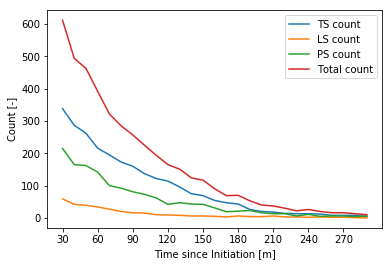

In [14]:
plt.plot(np.arange(30,300,10), TS[3:30], label='TS count')
plt.plot(np.arange(30,300,10), LS[3:30], label='LS count')
plt.plot(np.arange(30,300,10), PS[3:30], label='PS count')
plt.plot(np.arange(30,300,10), (TS+PS+LS)[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/counts.png')

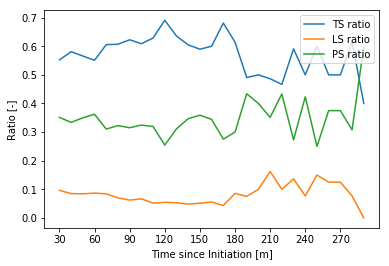

In [15]:
tot = (TS+PS+LS)

plt.plot(np.arange(30,300,10), (TS/tot)[3:30], label='TS ratio')
plt.plot(np.arange(30,300,10), (LS/tot)[3:30], label='LS ratio')
plt.plot(np.arange(30,300,10), (PS/tot)[3:30], label='PS ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/ratios.png')

In [5]:
def calc_mean_max_updrafts(system_tracks):
    ud = system_tracks['updrafts']
    ud_tilt = []
    tallest_ud = []
    mean_ud = []
    for i in range(len(ud)):
        ud_i = ud.iloc[i]
        ud_tilt_i = []
        for j in range(len(ud_i)):
            ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
            ud_tilt_i.append(ud_tilt_i_j)
       
        if ud_tilt_i != []:
            ud_tilt.append(ud_tilt_i)
            mean_ud.append(np.array(ud_tilt_i).mean(axis=0))
        else:
            ud_tilt.append(np.ones(3)*np.nan)
            mean_ud.append(np.ones(3)*np.nan)
        try:
            tallest_ind = np.argmax(np.array(ud_tilt_i)[:,0])
            tallest_ud.append(np.array(ud_tilt_i)[tallest_ind,:])
        except:
            tallest_ud.append(np.ones(3)*np.nan)
        
    return ud_tilt, mean_ud, tallest_ud
        
#     print(np.array(ud_tilt[2]).mean(axis=0))
#     print(np.array(ud_tilt[2]))
#     print(np.array(ud_tilt[2])[:,0])
#     tallest_ind = np.argmax(np.array(ud_tilt[2])[:,0])
#     np.array(ud_tilt[2])[tallest_ud,:]
# mean_ud

In [ ]:
ud_tilt, mean_ud, tallest_ud = calc_mean_max_updrafts(tracks_obj.system_tracks)

In [9]:

# np.array(tallest_ud)/np.array(tallest_ud)[:,0]
num = np.array(tallest_ud)
den = np.tile(np.array(mean_ud)[:,0], (3,1)).transpose()
ud_norm = (num/den)[:,1:]
ud_mag = np.sqrt(ud_norm[:,0] ** 2 + ud_norm[:,1] ** 2)
ud_dir = np.arctan2(ud_norm[:,0], ud_norm[:,1])
ud_dir = np.rad2deg(ud_dir)

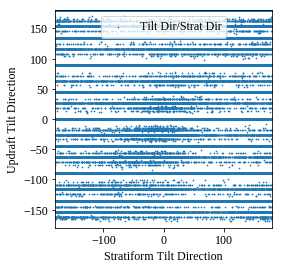

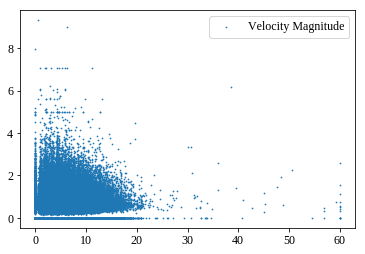

In [10]:
tracks_0 = tracks_obj.system_tracks
vel_dir = tracks_0['vel_dir'].values
vel_mag = np.sqrt(tracks_0['u_shift']**2 + tracks_0['v_shift']**2).values
tilt_dir = tracks_0['tilt_dir'].values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(tilt_dir, ud_dir, label='Tilt Dir/Strat Dir', s=.5)
plt.xlabel('Stratiform Tilt Direction')
plt.ylabel('Updraft Tilt Direction')
plt.xlim([-180, 180])
plt.ylim([-180, 180])
ax.set_aspect('equal')
# plt.plot( label='Updraft Tilt Direction')
plt.legend()
plt.figure()
plt.scatter(vel_mag, ud_mag, label='Velocity Magnitude', s=.5)
# plt.plot(ud_mag, label='Updraft Horizontal Tilt Magnitude')
plt.legend()